In [2]:
# import libraries
from time import sleep

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# load dataset
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

# training data loader
train_dataloader = DataLoader(train_data, batch_size=60000, shuffle=True)
# testing data loader
test_dataloader = DataLoader(test_data, batch_size=10000, shuffle=True)

In [5]:
train_iterator = iter(train_dataloader)
test_iterator = iter(test_dataloader)

# train_images, train_labels = next(train_iterator)
# train_images, train_labels = next(train_iterator)

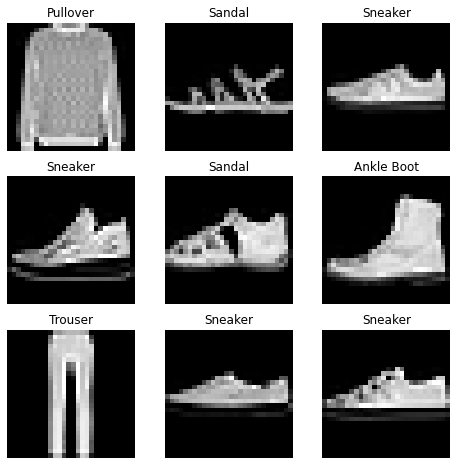

In [6]:
"""
Plot 8 samples from dataset
"""

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
# write encoder
class Encoder(nn.Module):
    """ENCODER MODULE THAT TAKES IN THE SIZE OF LATENT DIMENSIONS"""
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, device=device) # N, 1, 28, 28 -> N, 4, 24, 24
        self.conv2 = nn.Conv2d(4, 8, kernel_size=5, device=device) # N, 4, 24, 24 -> N, 8, 20, 20
        self.bn1 = nn.BatchNorm2d(8) # N, 8, 20, 20 -> N, 8, 20, 20
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, device=device) # N, 8, 20, 20 -> N, 16, 16, 16
        self.conv4 = nn.Conv2d(16, 32, kernel_size=5, device=device) # N, 16, 16, 16 -> N, 32, 12, 12
        self.bn2 = nn.BatchNorm2d(32) # N, 32, 12, 12 -> N, 32, 12, 12
        self.conv5 = nn.Conv2d(32, 32, kernel_size=5, device=device) # N, 32, 12, 12 -> N, 32, 8, 8
        self.conv6 = nn.Conv2d(32, 32, kernel_size=5, device=device) # N, 32, 8, 8 -> N, 32, 4, 4
        self.bn3 = nn.BatchNorm2d(32) # N, 32, 4, 4 -> N, 32, 4, 4

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.bn1(self.conv2(x)))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.bn2(self.conv4(x)))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.bn3(self.conv6(x)))
        x = x.view(-1, 32 * 4 * 4)
        return x


In [8]:
# write decoder
class Decoder(nn.Module):
    """DECODER MODULE THAT TAKES IN THE SIZE OF LATENT DIMENSIONS"""
    def __init__(self):
        super(Decoder, self).__init__()
        self.convTran6 = nn.ConvTranspose2d(32, 32, kernel_size=5, device=device)
        self.convTran5 = nn.ConvTranspose2d(32, 32, kernel_size=5, device=device)
        self.bn3 = nn.BatchNorm2d(32)
        self.convTran4 = nn.ConvTranspose2d(32, 16, kernel_size=5, device=device)
        self.convTran3 = nn.ConvTranspose2d(16, 8, kernel_size=5, device=device)
        self.bn2 = nn.BatchNorm2d(8)
        self.convTran2 = nn.ConvTranspose2d(8, 4, kernel_size=5, device=device)
        self.convTran1 = nn.ConvTranspose2d(4, 1, kernel_size=5, device=device)
        self.bn1 = nn.BatchNorm2d(1)
        
    def forward(self, x):
        x = x.view(-1, 32, 4, 4)
        x = F.leaky_relu(self.convTran6(x))
        x = F.leaky_relu(self.bn3(self.convTran5(x)))
        x = F.leaky_relu(self.convTran4(x))
        x = F.leaky_relu(self.bn2(self.convTran3(x)))
        x = F.leaky_relu(self.convTran2(x))
        x = F.leaky_relu(self.bn1(self.convTran1(x)))
        return x.view((-1, 1, 28, 28))

In [9]:
# write autoencoder
class AutoEncoder(nn.Module):
    """AUTOENCODER MODULE THAT TAKES IN THE SIZE OF LATENT DIMENSIONS"""
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [10]:
# Instantiate model
model = AutoEncoder().to(device=device)

# Hyperparameters
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
num_epochs = 100

In [11]:
# train autoencoder
loop = tqdm(iterable=range(num_epochs), total=len(range(num_epochs)))
for epoch in loop:
    sleep(0.1)
    for (images, _) in train_dataloader:
        # send data to device
        images = images.to(device=device)

        # predict
        predictions = model(images)

        # calculate loss
        loss = loss(predictions, images)

        # backprop
        optimizer.zero_grad()
        loss.backward()

        # gradient descent
        optimizer.step()

    # progressbar setup
    loop.set_description(desc=f"Executing epoch {epoch}/{num_epochs}")
    loop.set_postfix({"loss: ":loss.item()})

  0%|          | 0/100 [00:00<?, ?it/s]